# Applied Data Science Capstone - Final Project

Necessary libraries are imported.

In [91]:
import folium
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import requests

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


Create functions needed for the project.

In [141]:
# This function accepts a list of neighborhoods and their coordinates,
# runs Foursquare API calls to find venues within a 500 m radius, and 
# returns a dataframe with venue data along with the associated
# neighborhood data. Note, the API call restricts results to venues
# that fall under the Food category, which includes restaurants, cafes,
# bakeries, etc.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    categoryID = '4d4b7105d754a06374d81259' # categoryId for Food and includes subcategories
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryID)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# This function will take a row and sort its column values in descending
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


# This function will take an arbitrary cluster number and plot a bar chart of the top ten
# food-related vunues found within the cluster.
def plot_cluster(c_num):
    c = ny_merged.loc[ny_merged['Cluster Labels'] == c_num, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
    c_nh = c[['Neighborhood']] 
    c_nh = c_nh.merge(ny_totals, on=['Neighborhood'], how='inner')

    c_nh.loc['Total'] = c_nh.sum() # Add total row at bottom of dataframe
    c_nh.at['Total', 'Neighborhood'] = 'All neighborhoods' # Change value to remove concatenation of all neighborhood names

    tot_c = c_nh.loc[['Total']]
    tot_c = tot_c.drop(columns={'Neighborhood'}) # Drop the neighborhood column
    tot_c = tot_c.loc['Total'].sort_values(ascending=False) # Sort the categories in descending order
    tot_c = tot_c[:10].sort_values(ascending=True) # Take the top 10 categories only and then sort in ascending order

    fig = go.Figure(go.Bar(
                x=tot_c.values,
                y=tot_c.index,
                orientation='h'))

    fig.update_layout(
        title="Top 10 Food-related Venues in Cluster " + str(c_num),
        xaxis_title="Quantity",
    )

    fig.show()
    return

New york neighborhood data from a previous lab will be used for borough, neighborhood, latitude, and longitude data. First the json data file is loaded and then converted to a Pandas dataframe. 

In [3]:
# load newyork_data.json file saved locally
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# relevant data is in the features key    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# iterate through the data file and load into dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
# examine dataframe to ensure data loaded properly
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Inputs for the Foursquare API calls are provided below.

In [4]:
CLIENT_ID = 'QWY4VC2400IPL4J0SD2QKAZEGIZONTKSIZHUISFERHEXEYAL' # Foursquare ID
CLIENT_SECRET = '41QE3FJILXV0NQTVLIHES3SSOM15W1PXCRJSA3QRK0LBMK4O' # Foursquare Secret
ACCESS_TOKEN = 'EMJCVLIY21LOKJQLI0F13U0INVL4IVL3PNVFRPRT5RDCGKQP' # FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value. For the sake of simplicity, this will not be expanded for this project.

Food venue data for each neighborhood is compiled into a Pandas dataframe via the getNearbyVenues function defined previously.  

In [40]:
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [5]:
# This cell used to read in data retrieved from Foursquare API call via CSV file to save time and API usage limitations. 
#ny_venues = pd.read_csv('nyfoodvenues.csv')
#ny_venues = ny_venues.drop(columns='Unnamed: 0')
#ny_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant,40.898083,-73.850259,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
2,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
3,Wakefield,40.894705,-73.847201,Pitman Deli,40.896744,-73.844398,Food
4,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
...,...,...,...,...,...,...,...
8134,Queensbridge,40.756091,-73.945631,Imperial Gourmet Deli,40.754425,-73.941673,Deli / Bodega
8135,Fox Hills,40.617311,-74.081740,SUBWAY,40.618939,-74.082881,Sandwich Place
8136,Fox Hills,40.617311,-74.081740,Bums Pancake N Waffle Grill,40.618287,-74.085525,American Restaurant
8137,Fox Hills,40.617311,-74.081740,New pheonix,40.615379,-74.084969,Chinese Restaurant


Review the size of the resultant dataframe and first 5 rows to confirm data arrived as expected.

In [6]:
print(ny_venues.shape)
ny_venues.head()

(8139, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant,40.898083,-73.850259,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
2,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
3,Wakefield,40.894705,-73.847201,Pitman Deli,40.896744,-73.844398,Food
4,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega


The API calls take a considerable amount of time and count against the daily limit for the free-tier, so the results are saved to a CSV file for later use.

In [10]:
ny_venues.to_csv('nyfoodvenues.csv')

Let's see how many unique food-related venue categories are in the dataframe. 

In [7]:
print('There are {} uniques food-related venue categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 143 uniques food-related venue categories.


A one hot encoding dataframe is created to assign each venue to a venue category for summarization.

In [8]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

# examine the results
ny_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The rows are then grouped by neighborhood and the totals for each category of venue are totalized for each neighborhood. A total row is also added to summarize the total number of each venue category in all neighborhoods.

In [19]:
# Sum all categories for each neighborhood and group by neighborhood
ny_totals = ny_onehot.groupby('Neighborhood').sum().reset_index()
ny_totals.loc['Total'] = ny_totals.sum() # Add total row at bottom of dataframe
ny_totals.at['Total', 'Neighborhood'] = 'All neighborhoods' # Change value to remove concatenation of all neighborhood names
ny_totals

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,Allerton,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Annadale,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arden Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arlington,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Arrochar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,Woodlawn,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290,Woodrow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
291,Woodside,0,0,4,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292,Yorkville,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,2,1,0


To get an idea of the most popular food-related venues in New York City, we will look at the top ten most common food-related venues in New York City.

In [100]:
tot_ny = ny_totals.loc[['Total']]
tot_ny = tot_ny.drop(columns={'Neighborhood'}) # Drop the neighborhood column
tot_ny = tot_ny.loc['Total'].sort_values(ascending=False) # Sort the categories in descending order
tot_ny = tot_ny[:10].sort_values(ascending=True) # Take the top 10 categories only and then sort in ascending order

fig = go.Figure(go.Bar(
            x=tot_ny.values,
            y=tot_ny.index,
            orientation='h'))

fig.update_layout(
    title="Top 10 Food-related Venues in New York City",
    xaxis_title="Quantity",
)

fig.show()

From this initial visualization, we see what the most popular food-related venues are in the city. Now, we will move on assigning the neighborhoods to clusters based on their most common food-related venues.

The one hot encoding dataframe is first grouped by neighborhood and by taking the mean of the frequency of occurrence in each category.

In [183]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,Allerton,0.0,0.0,0.043478,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Annadale,0.0,0.0,0.166667,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,Arden Heights,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,Arlington,0.0,0.0,0.500000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,Arrochar,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,Woodhaven,0.0,0.0,0.000000,0.047619,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
289,Woodlawn,0.0,0.0,0.062500,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
290,Woodrow,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
291,Woodside,0.0,0.0,0.058824,0.014706,0.0,0.014706,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


A new dataframe is created to display the top 10 food-related venues for each neighborhood.

In [102]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Chinese Restaurant,Bakery,Fried Chicken Joint,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Food,Donut Shop
1,Annadale,Pizza Place,American Restaurant,Bakery,Sushi Restaurant,Restaurant,Diner,Deli / Bodega,Food,Portuguese Restaurant,Pet Café
2,Arden Heights,Deli / Bodega,Pizza Place,Afghan Restaurant,Polish Restaurant,Persian Restaurant,Peruvian Restaurant,Peruvian Roast Chicken Joint,Pet Café,Poke Place,Portuguese Restaurant
3,Arlington,American Restaurant,Deli / Bodega,Fast Food Restaurant,Afghan Restaurant,Portuguese Restaurant,Peruvian Restaurant,Peruvian Roast Chicken Joint,Pet Café,Pizza Place,Poke Place
4,Arrochar,Pizza Place,Italian Restaurant,Deli / Bodega,Bagel Shop,Polish Restaurant,Sandwich Place,Taco Place,Food Truck,Mediterranean Restaurant,Middle Eastern Restaurant


To determine the best number of clusters we iterate through several potential k values.

In [103]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(ny_grouped_clustering)
    kmeanModel.fit(ny_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(ny_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / ny_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(ny_grouped_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / ny_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



The k values are then plotted against distortion to try to best identify the elbow point.

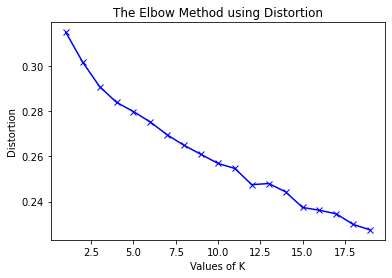

In [104]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Based on the above figure, we will call the elbow point K=12. The k-means clustering algorithm is then run with k set to 12.

In [105]:
# set number of clusters
kclusters = 12

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([10, 10,  7,  9, 10,  0,  0,  0,  0,  1])

The cluster label is column is then inserted into the dataframe containing the 10 most commone venue categories for each neighborhood. That dataframe is then merged with the original neighborhood dataframe.

In [108]:
# add clustering labels
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(columns=['Cluster Labels'])
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted.head()
ny_merged = neighborhoods

# merge ny_grouped with new york data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged = ny_merged.dropna()
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].astype(int)

ny_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,4,Sandwich Place,Food,Donut Shop,Pizza Place,Caribbean Restaurant,Deli / Bodega,Pet Café,Poke Place,Polish Restaurant,Portuguese Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,10,Pizza Place,Fast Food Restaurant,Restaurant,Fried Chicken Joint,Donut Shop,Deli / Bodega,Bagel Shop,Chinese Restaurant,Afghan Restaurant,Portuguese Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,4,Caribbean Restaurant,Deli / Bodega,Diner,Seafood Restaurant,Donut Shop,Chinese Restaurant,Bakery,Fast Food Restaurant,Pizza Place,Russian Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,5,Food Truck,Afghan Restaurant,Kebab Restaurant,Persian Restaurant,Peruvian Restaurant,Peruvian Roast Chicken Joint,Pet Café,Pizza Place,Poke Place,Polish Restaurant
5,Bronx,Kingsbridge,40.881687,-73.902818,1,Pizza Place,Deli / Bodega,Sandwich Place,Bakery,Chinese Restaurant,Donut Shop,Latin American Restaurant,Mexican Restaurant,Seafood Restaurant,Spanish Restaurant


Before we plot our clusters on a map of New York City, we first need to get coordinates for New York City so that the map visualization can be centered.

In [111]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


The map of New York City is plotted with each neighborhood color-coded by cluster to obtain an initial visualization of how the clusters are distributed.

In [327]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now to explore the individual clusters to assess how the venue categories are distributed in each of them.

First, we look at cluster 0.

In [145]:
plot_cluster(0)

Cluster 1

In [146]:
plot_cluster(1)

Cluster 2

In [147]:
plot_cluster(2)

Cluster 3

In [148]:
plot_cluster(3)

Cluster 4

In [149]:
plot_cluster(4)

Cluster 5

In [150]:
plot_cluster(5)

Cluster 6

In [151]:
plot_cluster(6)

Cluster 7

In [152]:
plot_cluster(7)

Cluster 8

In [153]:
plot_cluster(8)

Cluster 9

In [154]:
plot_cluster(9)

Cluster 10

In [155]:
plot_cluster(10)

Cluster 11

In [156]:
plot_cluster(11)

Analyzing 12 different bar charts is not the easiest way to assess the clusters. So, we will create a new data frame that displays the frequency distribution of all food-related venues in each cluster along with the frequency distribution for the entire city. To assess the size of the clusters, the total number of neighborhoods in each cluster is also included in the dataframe.

In [247]:
freq_ny = ny_totals.loc[['Total']]
freq_ny = freq_ny.drop(columns={'Neighborhood'})
tot_venues = freq_ny.values.sum()
freq_ny = freq_ny / tot_venues
freq_ny.insert(0, 'Neighborhood Count', ny_grouped.shape[0] - 1)

for k in range(kclusters):
    c = ny_merged.loc[ny_merged['Cluster Labels'] == k, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
    c_nh = c[['Neighborhood']] 
    c_nh = c_nh.merge(ny_totals, on=['Neighborhood'], how='inner')
    c_nh.loc['Total'] = c_nh.sum() # Add total row at bottom of dataframe
    tot_c = c_nh.loc[['Total']]
    tot_c = tot_c.drop(columns={'Neighborhood'}) # Drop the neighborhood column
    tot_c.rename(index={'Total':k},inplace=True)
    tot_c_venues = tot_c.values.sum()
    tot_c = tot_c / tot_c_venues
    tot_c.insert(0, 'Neighborhood Count', c_nh.shape[0] -1)
    freq_ny = freq_ny.append(tot_c)

freq_ny

,Neighborhood Count,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
Total,293,0.000369,0.000737,0.032559,0.001106,0.001229,0.012532,0.000737,0.000246,0.003932,...,0.000123,0.002457,0.000491,0.000123,0.000123,0.007741,0.000123,0.007249,0.002703,0.000123
0,102,0.000199,0.000598,0.044077,0.001396,0.001795,0.011568,0.000997,0.000199,0.004388,...,0.000199,0.003590,0.000798,0.000199,0.000199,0.010371,0.000199,0.010172,0.002593,0.000199
1,59,0.000755,0.000755,0.012840,0.000000,0.000000,0.016616,0.000755,0.000755,0.003021,...,0.000000,0.000755,0.000000,0.000000,0.000000,0.003776,0.000000,0.005287,0.003776,0.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,67,0.000796,0.001592,0.013535,0.000796,0.000796,0.010350,0.000000,0.000000,0.004777,...,0.000000,0.000796,0.000000,0.000000,0.000000,0.005573,0.000000,0.001592,0.000796,0.000000
5,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


Since we are only intersted in the most popular venue categories in the entire city, we filter the datafram accordingly.

In [256]:
filtered = freq_ny[{'Neighborhood Count','Pizza Place', 'Deli / Bodega',
                    'Chinese Restaurant', 'Italian Restaurant', 'Bakery',
                    'Café', 'Mexican Restaurant', 'Sandwich Place',
                    'American Restaurant', 'Donut Shop'}]
filtered

,Pizza Place,Café,Sandwich Place,American Restaurant,Italian Restaurant,Deli / Bodega,Mexican Restaurant,Chinese Restaurant,Bakery,Donut Shop,Neighborhood Count
Total,0.088832,0.037965,0.033296,0.032559,0.058730,0.086374,0.036737,0.059712,0.044109,0.026170,293
0,0.070203,0.048863,0.028919,0.044077,0.077583,0.051456,0.038692,0.032310,0.041883,0.015756,102
1,0.088369,0.015861,0.044562,0.012840,0.023414,0.063444,0.027190,0.140483,0.054381,0.057402,59
2,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,2
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3
4,0.078025,0.027070,0.039809,0.013535,0.038217,0.203025,0.042994,0.073248,0.042994,0.036624,67
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
7,0.133333,0.000000,0.033333,0.000000,0.033333,0.600000,0.000000,0.033333,0.000000,0.000000,7
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


We now want to see how the frequency distribution for each of the top ten food-related venues differs from that of the total city. So, we create a new dataframe to hold the differences.

In [269]:
delta = filtered[1:]
delta = filtered.loc['Total'] - delta
delta = delta.drop(columns={'Neighborhood Count'})
delta

,Pizza Place,Café,Sandwich Place,American Restaurant,Italian Restaurant,Deli / Bodega,Mexican Restaurant,Chinese Restaurant,Bakery,Donut Shop
0,0.018628,-0.010898,0.004377,-0.011517,-0.018853,0.034918,-0.001955,0.027403,0.002226,0.010414
1,0.000463,0.022104,-0.011265,0.019719,0.035316,0.022930,0.009546,-0.080771,-0.010272,-0.031232
2,-0.036168,0.037965,0.033296,0.032559,0.058730,0.086374,0.036737,-0.065288,0.044109,0.026170
3,0.088832,0.037965,0.033296,0.032559,0.058730,-0.913626,0.036737,0.059712,0.044109,0.026170
4,0.010806,0.010895,-0.006512,0.019024,0.020513,-0.116651,-0.006257,-0.013536,0.001115,-0.010454
5,0.088832,0.037965,0.033296,0.032559,0.058730,0.086374,0.036737,0.059712,0.044109,0.026170
6,0.088832,0.037965,0.033296,0.032559,0.058730,0.086374,0.036737,0.059712,0.044109,0.026170
7,-0.044502,0.037965,-0.000037,0.032559,0.025396,-0.513626,0.036737,0.026379,0.044109,0.026170
8,0.088832,0.037965,0.033296,0.032559,0.058730,0.086374,0.036737,0.059712,0.044109,0.026170
9,0.088832,0.037965,0.033296,-0.522996,0.058730,-0.135848,0.036737,0.059712,0.044109,0.026170


To help us determine the best choice for a new venue, we look at the maximum differences in each venue category and sort them.

In [329]:
results = pd.DataFrame(delta.max())
results = results.sort_values(by=0, ascending=False)
results.rename(columns={0:'Difference'}, inplace=True)
results

,Difference
Pizza Place,0.088832
Deli / Bodega,0.086374
Chinese Restaurant,0.059712
Italian Restaurant,0.058730
Bakery,0.044109
Café,0.037965
Mexican Restaurant,0.036737
Sandwich Place,0.033296
American Restaurant,0.032559
Donut Shop,0.026170


We see that the venue category Pizza Place has the highest difference value. Looking at the dataframe, we see that clusters 3, 5, 6, 8, 9, and 11 all share this maximum difference value. We then conclude that opening a Pizza Place in one of the neighborhoods belonging to these clusters may be a good choice.

To see where these neighborhoods are situated in the city, we filter the ny_merged data frames by these clusters and plot the results on a map of New York City.

In [335]:
ny_merged_filtered = ny_merged.loc[(ny_merged['Cluster Labels'] == 3) |
                                   (ny_merged['Cluster Labels'] == 5) |
                                   (ny_merged['Cluster Labels'] == 6) |
                                   (ny_merged['Cluster Labels'] == 8) |
                                   (ny_merged['Cluster Labels'] == 9) |
                                   (ny_merged['Cluster Labels'] == 11)]

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged_filtered['Latitude'],
                                  ny_merged_filtered['Longitude'],
                                  ny_merged_filtered['Neighborhood'],
                                  ny_merged_filtered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Finally, a listing of the neighborhoods included in these clusters.

In [334]:
ny_merged_filtered['Neighborhood']

4            Riverdale
85            Sea Gate
150         Whitestone
193         Brookville
202        Grymes Hill
204        South Beach
217        Tottenville
219        Silver Lake
226       Graniteville
227          Arlington
255       Emerson Hill
257       Howland Hook
261    Paerdegat Basin
287        Egbertville
292    Lighthouse Hill
294              Malba
Name: Neighborhood, dtype: object